# Project # 2

Hayoung Kim - hk26786

Mandeep Singh Burdak - msb4384

Nicolas Rey - ner785

Sanjana Nayak - svn378

In [75]:
#!pip install gurobipy

In [1]:
# Import libraries
import os
import os.path
import numpy as np
import gurobipy as gp
import pandas as pd

### Reading and transforming data

In [3]:
# Read the csv with stocks data
basedata = pd.read_csv('stocks2019.csv')
testdata = pd.read_csv('stocks2020.csv')
gurobi_time_limit = 3600

In [4]:
## 2019 DATA
# Calculate the returns
returns = basedata.copy()
for column in basedata.columns[1:]:
    returns[column] = (basedata[column] / basedata[column].shift(1)) -1
returns = returns.dropna()

# Calculate target and independets variables
index = returns.iloc[:,1]
returns1 = returns.iloc[:, 2:]
ret = returns1.to_numpy()
q = index.to_numpy()

# Get the number of stocks and dates
t,n = returns1.shape
stocks = list(returns1.columns)

# Calculate the correlation matrix
phi=np.corrcoef(ret,rowvar=False)

## 2020 DATA
# Calculate the returns
returns20 = testdata.copy()
for column in testdata.columns[1:]:
    returns20[column] = (testdata[column] / testdata[column].shift(1)) -1
returns20 = returns20.dropna()

# Calculate target and independets variables
index20 = returns20.iloc[:,1]
ret_test = returns20.iloc[:, 2:]
q_test = index20.to_numpy()
t_test,n_test = returns20.shape

In [5]:
print('NR_INFO: Number of stocks: ', n)
print('NR_INFO: Number of days: ', t)

NR_INFO: Number of stocks:  100
NR_INFO: Number of days:  250


## Model 1

In [6]:
env = gp.Env()
env.setParam('TimeLimit',gurobi_time_limit)

Restricted license - for non-production use only - expires 2024-10-28
Set parameter TimeLimit to value 3600


In [7]:
def model_1(m = 5):
    df_result = pd.DataFrame()
    
    ## MODEL 1.1 - FINDING STOCKS
    # Creating model
    finder=gp.Model(env=env)
    finder.Params.OutputFlag=0

    ## Variables
    # xij = 1 if stock j in index is the most similar stock i, 0 otherwise
    x = finder.addMVar(shape=(n,n), vtype='B')
    # yj = 1 if j is selected in the fund, 0 otherwise
    y = finder.addMVar(n, vtype='B')

    ## Obj. function
    # The objective of the model maximizes the similarity between the n stocks and their representatives in the fund.
    finder.setObjective(gp.quicksum(phi[i][j]*x[i][j] for i in range(n) for j in range(n)),sense=gp.GRB.MAXIMIZE)

    ## Constraints
    # Max m(5 default) stocks in the fund
    f1 = finder.addConstr(gp.quicksum(y[j] for j in range(n))==m)
    # Each stock in NASDAQ should be represented by on of the stock's found
    f2 = finder.addConstrs(gp.quicksum(x[i][j] for j in range(n))==1 for i in range(n))
    # X-Y relationship
    f3 = finder.addConstrs(x[i][j]<=y[j] for i in range(n) for j in range(n))
    finder.optimize()


    M = np.where(y.x > 0.5, 1, 0)

    ## MODEL 1.2 - DEFINING WEIGHTS
    # Creating model
    weigher=gp.Model(env=env)
    weigher.Params.OutputFlag=0

    a = weigher.addMVar(n)
    b = weigher.addMVar(t)

    weigher.setObjective(gp.quicksum(b[i] for i in range(t)))

    # Making the abs value
    w1 = weigher.addConstrs(q[i]-gp.quicksum(a[j]*ret[i][j] for j in range(n)) <= b[i] for i in range(t))
    w2 = weigher.addConstrs(gp.quicksum(a[j]*ret[i][j] for j in range(n))-q[i] <= b[i] for i in range(t))
    # We are just using the stocks that we found
    w3 = weigher.addConstrs(a[i]<=M[i] for i in range(n))
    # Weights should be equal to 1
    w4 = weigher.addConstr(gp.quicksum(a[i] for i in range(n)) == 1)
    weigher.optimize()

    # Iterate through the arrays and print stocks where you are investing along with their weights
    #print(f"\nSelecting {m} stocks, the objective value is {weigher.objVal}")
    #for i in range(len(stocks)):
    #    if M[i] == 1:
    #        print(f"Investing in {stocks[i]} with weight of {a.x[i]}")
    df_result['stock'] = [stocks[i] for i in range(len(M)) if M[i] == 1]
    df_result['weight'] = [a.x[i] for i in range(len(M)) if M[i] == 1]
    df_result['m'] = m
    
    return weigher.objVal, df_result


In [14]:
#model_1()

In [8]:
emes = [5,10,20,30,40,50,60,70,80,90,100]
li_obj_1 = []
li_res_1 = []
li_obj_1t = []
li_res_1t = []

if os.path.isfile('weights1.csv'):
    weights1=pd.read_csv('weights1.csv')
    weights1=weights1.drop(columns=['Unnamed: 0'])
    for m in emes:
        res=pd.DataFrame(weights1[weights1['m']==m])
        li_res_1t.append(res.reset_index())
        for stock, weight, m in zip(res['stock'], res['weight'], res['m']):
            li_res_1.append([stock, weight, m])
    li_res_1 = pd.DataFrame(li_res_1, columns=['stock', 'weight', 'm'])
else:
    for m in emes:
        obj, res = model_1(m)
        li_obj_1t.append(obj)
        li_res_1t.append(res)
        for stock, weight, m in zip(res['stock'], res['weight'], res['m']):
            li_res_1.append([stock, weight, m])
            li_obj_1.append(obj)
    li_res_1 = pd.DataFrame(li_res_1, columns=['stock', 'weight', 'm'])
    li_res_1.to_csv('weights1.csv')

GurobiError: Model too large for size-limited license; visit https://www.gurobi.com/free-trial for a full license

In [84]:
error_train1=[]
for i in range(len(emes)):
    sum_ret=[0]*t
    for j in range(len(li_res_1t[i])):
        sum_ret+=returns1[li_res_1t[i]['stock'][j]]*li_res_1t[i]['weight'][j]
    error_train1.append(sum(abs(q-sum_ret)))
error_test1=[]
for i in range(len(emes)):
    sum_ret=[0]*t_test
    for j in range(len(li_res_1t[i])):
        sum_ret+=ret_test[li_res_1t[i]['stock'][j]]*li_res_1t[i]['weight'][j]
    error_test1.append(sum(abs(q_test-sum_ret)))

In [85]:
result_1=pd.DataFrame({'m':emes,'Error':error_test1})

In [86]:
result_1

,m,Error
0,5,1.112437
1,10,1.102404
2,20,0.855213
3,30,0.771210
4,40,0.791736
5,50,0.772100
6,60,0.747841
7,70,0.557854
8,80,0.537323
9,90,0.367790


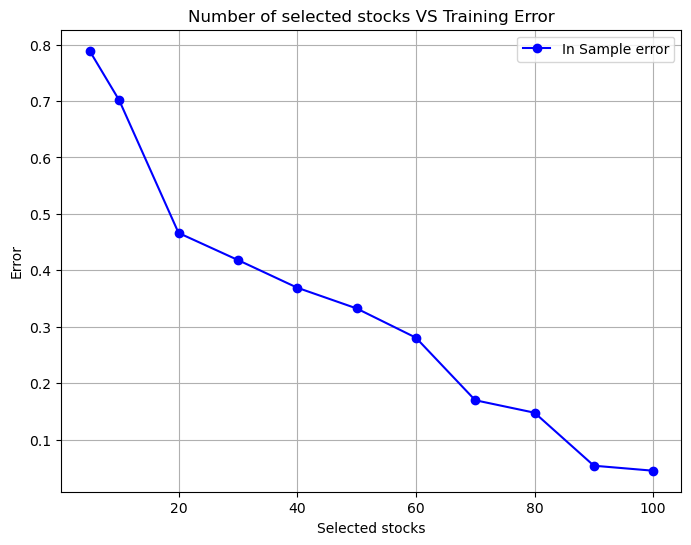

In [87]:
import matplotlib.pyplot as plt

# Create a line chart
plt.figure(figsize=(8, 6))  # Optional: Set the figure size
plt.plot(emes, error_train1, marker='o', color='b', label='In Sample error')  # marker='o' adds circles at data points
plt.xlabel('Selected stocks')  # X-axis label
plt.ylabel('Error')  # Y-axis label
plt.title('Number of selected stocks VS Training Error')  # Chart title
plt.legend()  # Show legend (label)
plt.grid(True)  # Show grid lines
plt.show()  # Display the chart

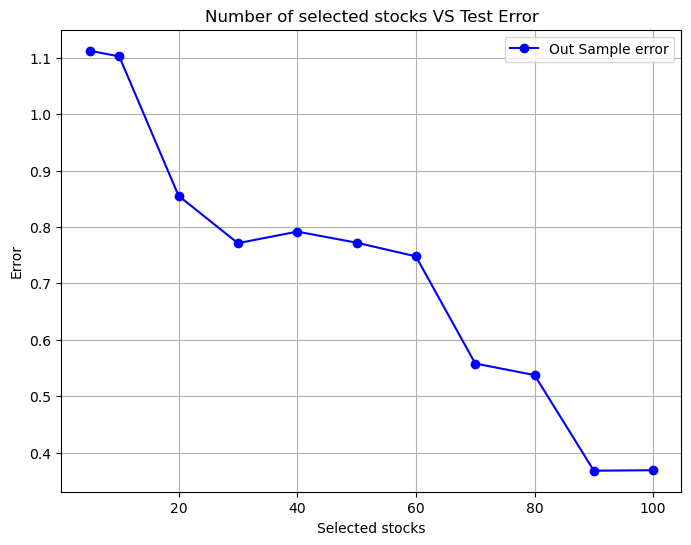

In [88]:
import matplotlib.pyplot as plt

# Create a line chart
plt.figure(figsize=(8, 6))  # Optional: Set the figure size
plt.plot(emes, error_test1, marker='o', color='b', label='Out Sample error')  # marker='o' adds circles at data points
plt.xlabel('Selected stocks')  # X-axis label
plt.ylabel('Error')  # Y-axis label
plt.title('Number of selected stocks VS Test Error')  # Chart title
plt.legend()  # Show legend (label)
plt.grid(True)  # Show grid lines
plt.show()  # Display the chart

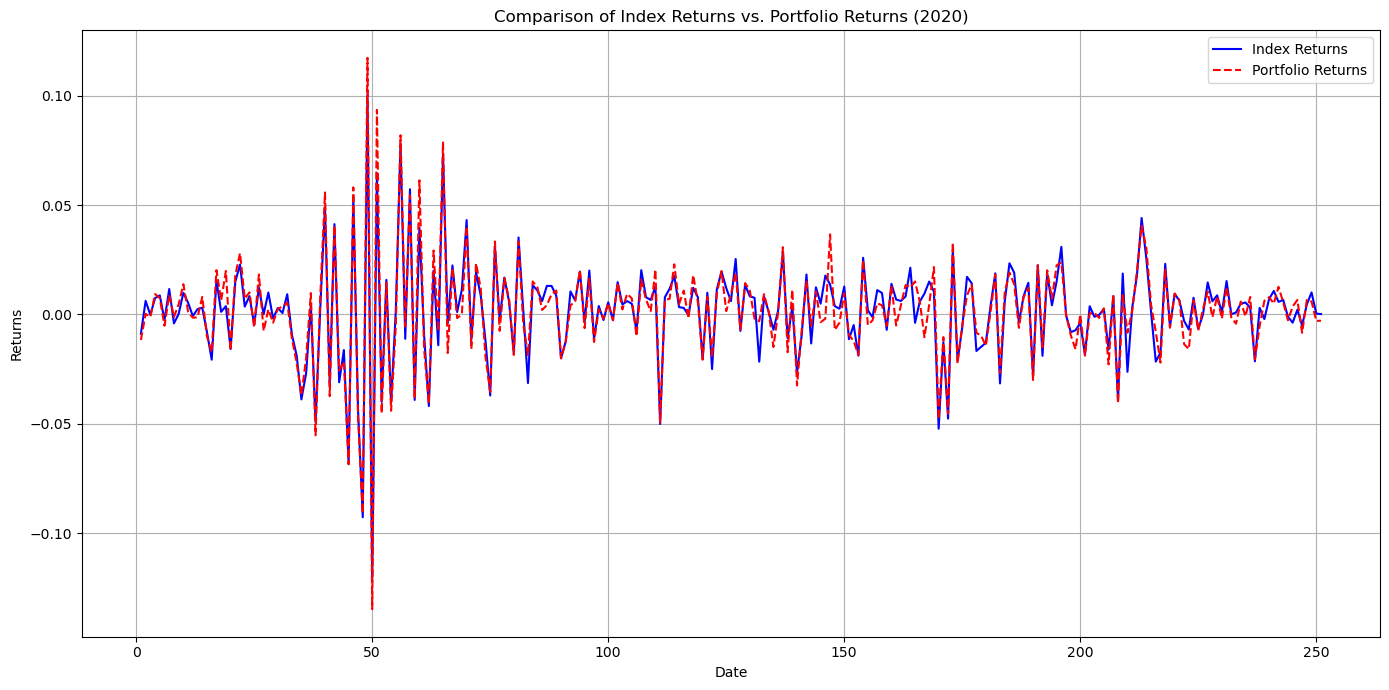

In [118]:
import matplotlib.pyplot as plt
obj_1, df_weights = model_1()
portfolio_returns_2020 =returns20[df_weights.stock].dot(list(df_weights.weight))
index_returns_2020 = testdata.iloc[:,1]

# Plotting the data
plt.figure(figsize=(14, 7))
plt.plot(index20.index, index20.values, label='Index Returns', color='blue')
plt.plot(portfolio_returns_2020.index, portfolio_returns_2020.values, label='Portfolio Returns', color='red', linestyle='--')
plt.title('Comparison of Index Returns vs. Portfolio Returns (2020)')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

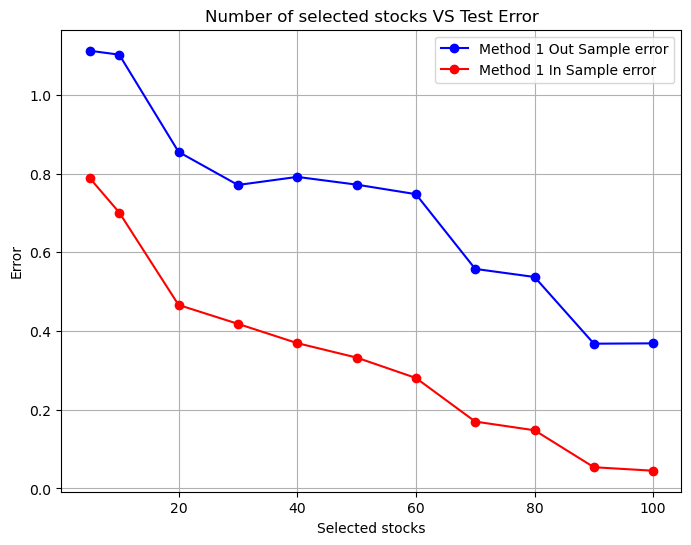

In [90]:
plt.figure(figsize=(8, 6))  # Optional: Set the figure size
plt.plot(emes, error_test1, marker='o', color='b', label='Method 1 Out Sample error')
plt.plot(emes, error_train1, marker='o', color='r', label='Method 1 In Sample error')

plt.xlabel('Selected stocks')  # X-axis label
plt.ylabel('Error')  # Y-axis label
plt.title('Number of selected stocks VS Test Error')  # Chart title
plt.legend()  # Show legend (label)
plt.grid(True)  # Show grid lines
plt.show()  # Display the chart

# Model 2

In [92]:

def model_2(g=5):
    df_result = pd.DataFrame()
    stocker=gp.Model(env=env)
    stocker.Params.OutputFlag = 0
    
    x = stocker.addMVar(n,vtype='C')
    y = stocker.addMVar(n,vtype='B')
    z = stocker.addMVar(t,vtype='C')
    stocker.setObjective(gp.quicksum(z[i] for i in range(t)))
    # Max g stocks
    c1 = stocker.addConstr(gp.quicksum(y[i] for i in range(n))==g)
    # Big M constraint
    c2 = stocker.addConstrs(x[i]<=y[i] for i in range(n))
    # Sum up to 1
    c3 = stocker.addConstr(gp.quicksum(x[i] for i in range(n))==1)
    # Abs values
    c4 = stocker.addConstrs(q[i]-gp.quicksum(x[j]*ret[i][j] for j in range(n)) <= z[i] for i in range(t))
    c5 = stocker.addConstrs(gp.quicksum(x[j]*ret[i][j] for j in range(n))-q[i] <= z[i] for i in range(t))
    stocker.optimize()
    df_result['stock'] = [stocks[i] for i in range(len(y.x)) if y.x[i] == 1]
    df_result['weight'] = [x.x[i] for i in range(len(y.x)) if y.x[i] == 1]
    df_result['m'] = g
    return stocker.objVal, df_result

In [93]:
model_2()

(0.4992586920546358,
   stock    weight  m
 0  AMZN  0.250123  5
 1   ADI  0.113758  5
 2  AAPL  0.191692  5
 3  MSFT  0.289869  5
 4  MDLZ  0.154558  5)

In [91]:
emes = [5,10,20,30,40,50,60,70,80,90,100]
li_obj_2 = []
li_res_2 = []
li_obj_2t = []
li_res_2t = []

if os.path.isfile('weights2.csv'):
    weights2=pd.read_csv('weights2.csv')
    weights2=weights2.drop(columns=['Unnamed: 0'])
    for m in emes:
        res=pd.DataFrame(weights2[weights2['m']==m])
        li_res_2t.append(res.reset_index())
        for stock, weight, m in zip(res['stock'], res['weight'], res['m']):
            li_res_2.append([stock, weight, m])
    li_res_2 = pd.DataFrame(li_res_2, columns=['stock', 'weight', 'm'])
else:
    for m in emes:
        obj, res = model_2(m)
        li_obj_2t.append(obj)
        li_res_2t.append(res)
        for stock, weight, m in zip(res['stock'], res['weight'], res['m']):
            li_res_2.append([stock, weight, m])
            li_obj_2.append(obj)
    li_res_2 = pd.DataFrame(li_res_2, columns=['stock', 'weight', 'm'])
    li_res_2.to_csv('weights2.csv')

In [92]:
error_train2=[]
for i in range(len(emes)):
    sum_ret=[0]*t
    for j in range(len(li_res_2t[i])):
        sum_ret+=returns1[li_res_2t[i]['stock'][j]]*li_res_2t[i]['weight'][j]
    error_train2.append(sum(abs(q-sum_ret)))
error_test2=[]
for i in range(len(emes)):
    sum_ret=[0]*t_test
    for j in range(len(li_res_2t[i])):
        sum_ret+=ret_test[li_res_2t[i]['stock'][j]]*li_res_2t[i]['weight'][j]
    error_test2.append(sum(abs(q_test-sum_ret)))

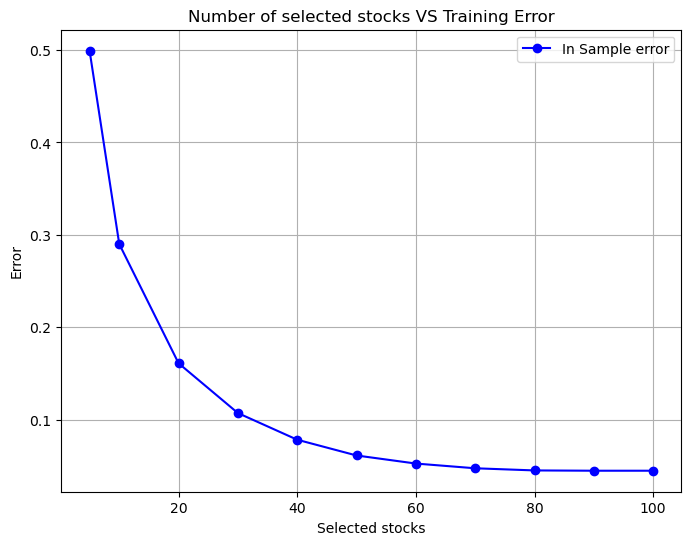

In [93]:
import matplotlib.pyplot as plt

# Create a line chart
plt.figure(figsize=(8, 6))  # Optional: Set the figure size
plt.plot(emes, error_train2, marker='o', color='b', label='In Sample error')  # marker='o' adds circles at data points
plt.xlabel('Selected stocks')  # X-axis label
plt.ylabel('Error')  # Y-axis label
plt.title('Number of selected stocks VS Training Error')  # Chart title
plt.legend()  # Show legend (label)
plt.grid(True)  # Show grid lines
plt.show()  # Display the chart

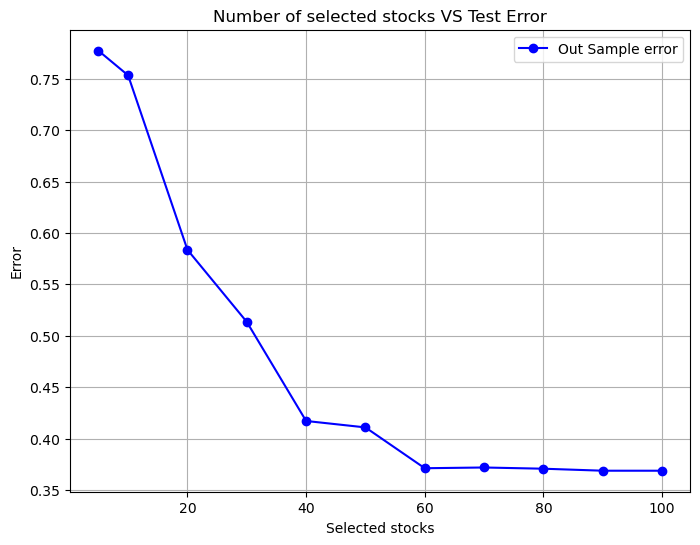

In [94]:
import matplotlib.pyplot as plt

# Create a line chart
plt.figure(figsize=(8, 6))  # Optional: Set the figure size
plt.plot(emes, error_test2, marker='o', color='b', label='Out Sample error')  # marker='o' adds circles at data points
plt.xlabel('Selected stocks')  # X-axis label
plt.ylabel('Error')  # Y-axis label
plt.title('Number of selected stocks VS Test Error')  # Chart title
plt.legend()  # Show legend (label)
plt.grid(True)  # Show grid lines
plt.show()  # Display the chart

In [95]:
result_2=pd.DataFrame({'m':emes,'Error':error_test2})

In [96]:
result_2

,m,Error
0,5,0.777362
1,10,0.753372
2,20,0.583628
3,30,0.513487
4,40,0.417077
5,50,0.410822
6,60,0.371097
7,70,0.371814
8,80,0.370629
9,90,0.368682



Interrupt request received


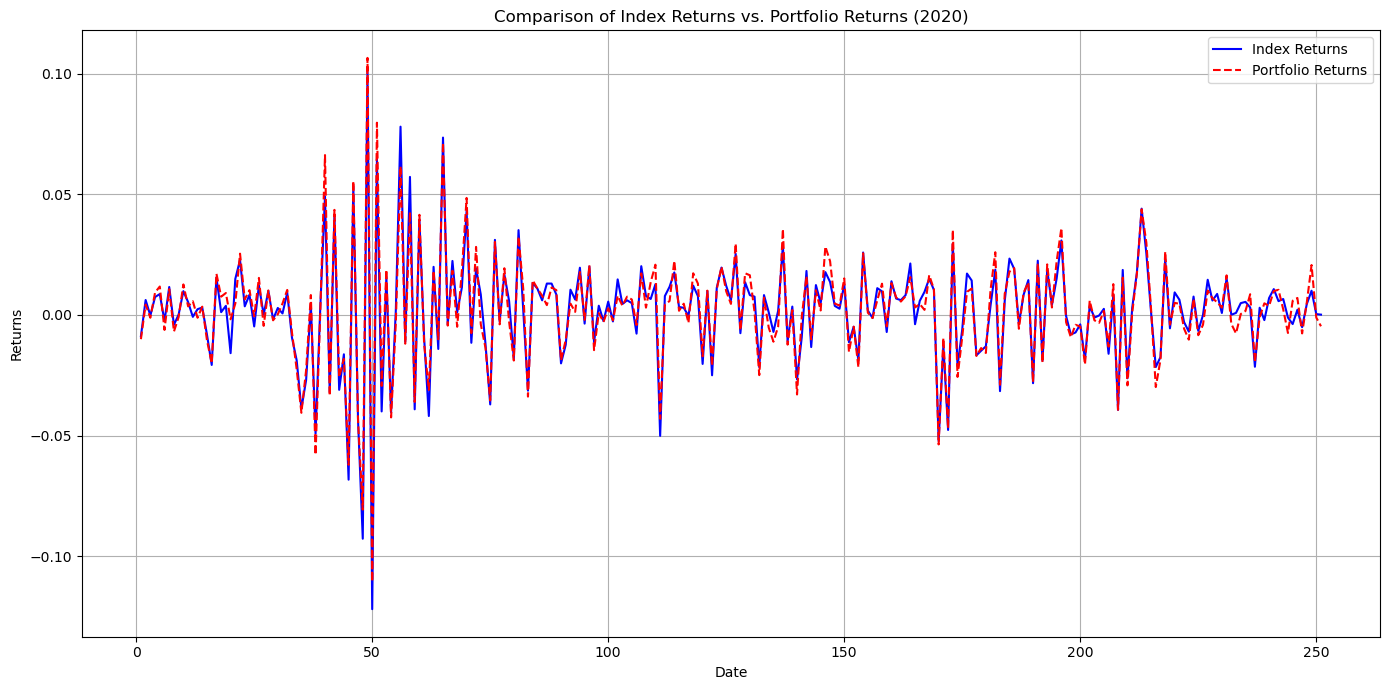

In [109]:
import matplotlib.pyplot as plt
obj_2, df_weights = model_2()
portfolio_returns_2020 =returns20[df_weights.stock].dot(list(df_weights.weight))
index_returns_2020 = testdata.iloc[:,1]

# Plotting the data
plt.figure(figsize=(14, 7))
plt.plot(index20.index, index20.values, label='Index Returns', color='blue')
plt.plot(portfolio_returns_2020.index, portfolio_returns_2020.values, label='Portfolio Returns', color='red', linestyle='--')
plt.title('Comparison of Index Returns vs. Portfolio Returns (2020)')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

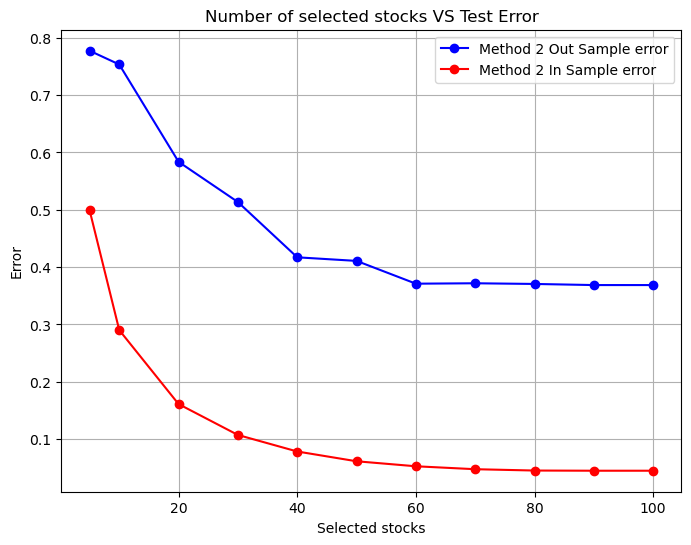

In [97]:
plt.figure(figsize=(8, 6))  # Optional: Set the figure size
plt.plot(emes, error_test2, marker='o', color='b', label='Method 2 Out Sample error')  # marker='o' adds circles at data points
plt.plot(emes, error_train2, marker='o', color='r', label='Method 2 In Sample error')  # marker='o' adds circles at data points

plt.xlabel('Selected stocks')  # X-axis label
plt.ylabel('Error')  # Y-axis label
plt.title('Number of selected stocks VS Test Error')  # Chart title
plt.legend()  # Show legend (label)
plt.grid(True)  # Show grid lines
plt.show()  # Display the chart

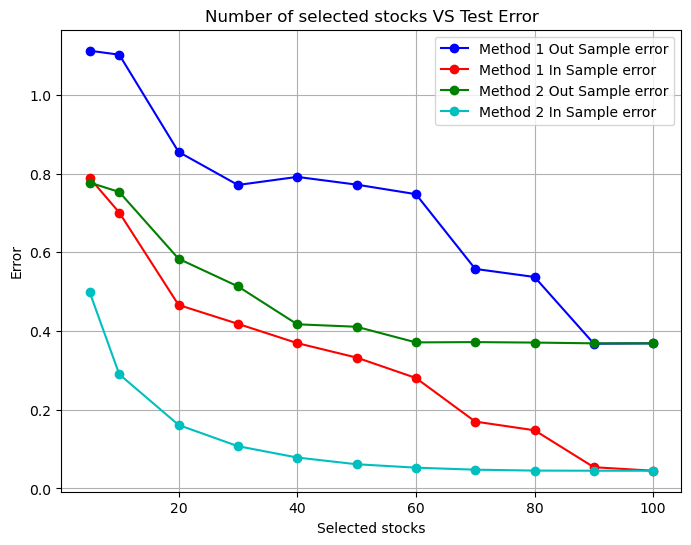

In [98]:
plt.figure(figsize=(8, 6))  # Optional: Set the figure size
plt.plot(emes, error_test1, marker='o', color='b', label='Method 1 Out Sample error')  # marker='o' adds circles at data points
plt.plot(emes, error_train1, marker='o', color='r', label='Method 1 In Sample error')  # marker='o' adds circles at data points
plt.plot(emes, error_test2, marker='o', color='g', label='Method 2 Out Sample error')
plt.plot(emes, error_train2, marker='o', color='c', label='Method 2 In Sample error')

plt.xlabel('Selected stocks')  # X-axis label
plt.ylabel('Error')  # Y-axis label
plt.title('Number of selected stocks VS Test Error')  # Chart title
plt.legend()  # Show legend (label)
plt.grid(True)  # Show grid lines
plt.show()  # Display the chart